In [1]:
import pandas as pd
import numpy as np
import bs4 as bs
from datetime import datetime
import time

from IPython.display import clear_output
from tqdm import tqdm, trange

Скачаем данные

In [423]:
with open('AOL-user-ct-collection/user-ct-test-collection-01.txt') as file:
    data_aol = [line.strip().split('\t') for line in file.readlines()][1:]
    
with open('AOL-user-ct-collection/user-ct-test-collection-02.txt') as file:
    data_aol += [line.strip().split('\t') for line in file.readlines()][1:]
    
with open('AOL-user-ct-collection/user-ct-test-collection-03.txt') as file:
    data_aol += [line.strip().split('\t') for line in file.readlines()][1:]
    
with open('AOL-user-ct-collection/user-ct-test-collection-04.txt') as file:
    data_aol += [line.strip().split('\t') for line in file.readlines()][1:]
    
with open('AOL-user-ct-collection/user-ct-test-collection-05.txt') as file:
    data_aol += [line.strip().split('\t') for line in file.readlines()][1:]
    
with open('AOL-user-ct-collection/user-ct-test-collection-06.txt') as file:
    data_aol += [line.strip().split('\t') for line in file.readlines()][1:]
    
with open('AOL-user-ct-collection/user-ct-test-collection-07.txt') as file:
    data_aol += [line.strip().split('\t') for line in file.readlines()][1:]
    
with open('AOL-user-ct-collection/user-ct-test-collection-08.txt') as file:
    data_aol += [line.strip().split('\t') for line in file.readlines()][1:]
    
with open('AOL-user-ct-collection/user-ct-test-collection-09.txt') as file:
    data_aol += [line.strip().split('\t') for line in file.readlines()][1:]
    
with open('AOL-user-ct-collection/user-ct-test-collection-10.txt') as file:
    data_aol_test = [line.strip().split('\t') for line in file.readlines()][1:]

Посмотрим на уникальное количество пользователей.

In [60]:
unique_users_train, count_users_train = np.unique([line[0] for line in data_aol], return_counts=True)
unique_users_test, count_users_test = np.unique([line[0] for line in data_aol_test], return_counts=True)
print('Count of unique users in train = {}, Count of unique users in test = {}'.format(len(unique_users_train),
                                                                                       len(unique_users_test)))

Count of unique users in train = 591773, Count of unique users in test = 65654


Посмотрим на пересечения юзеров между трейном и тестом. Пересечение пустое. Остюда можно сделать вывод, что разбиение на тест и трейн корректно. 

In [61]:
np.intersect1d(unique_users_train, unique_users_test)

array([], dtype='<U8')

Токинизируем запросы при помощи WordPunctTokenizer.

In [6]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

for i in range(1, len(data_aol)):
    data_aol[i][1] = ' '.join(tokenizer.tokenize(data_aol[i][1].lower()))
    dtime = datetime.strptime(data_aol[i][2], "%Y-%m-%d %H:%M:%S")
    data_aol[i][2] = time.mktime(dtime.timetuple())

for i in range(1, len(data_aol_test)):
    data_aol_test[i][1] = ' '.join(tokenizer.tokenize(data_aol_test[i][1].lower()))
    dtime = datetime.strptime(data_aol_test[i][2], "%Y-%m-%d %H:%M:%S")
    data_aol_test[i][2] = time.mktime(dtime.timetuple())

In [2]:
#save/load

# import pickle 

# with open('data_aol.pickle', 'wb') as f:
#     pickle.dump(data_aol, f)

# with open('data_aol_test.pickle', 'wb') as f:
#     pickle.dump(data_aol_test, f)
    
# with open('data_aol.pickle', 'rb') as f:
#     data_aol = pickle.load(f)
        
# with open('data_aol_test.pickle', 'rb') as f:
#     data_aol_test = pickle.load(f)

Наша будущая модель будет предсказывать продолжение запроса по уже написанной части предсказываемого запроса и по текущей сессии. Под текущей сессией я решила понимать запросы, расположенные друг от друга не больше, чем на пол часа. При этом я рассматриваю только максимум 6 предыдущих запросов. <br>
Таким образом, в качестве одного объекта, который будем подавать в модель, нужно взять последовательность запросов (не больше 6) из одной сессии одного юзера. При этом мы не хотим брать объект вида один запрос. Найдем подходящие индексы, чтобы потом быстрее семплить при построении батча.

In [4]:
max_query_sequence_len = 6
session_time = 30 * 60 # 30 minutes

count_prev_good_indeces = [0]
prev_time = data_aol[0][2]
prev_user_id = data_aol[0][0]

cur_good_count = 1
for i in range(1, len(data_aol)):
    if data_aol[i][2] - prev_time < session_time and data_aol[i][0] == prev_user_id:
        count_prev_good_indeces.append(cur_good_count)
        cur_good_count += 1
    else:
        count_prev_good_indeces.append(0)
        cur_good_count = 1
    prev_user_id = data_aol[i][0]
    prev_time = data_aol[i][2]

In [5]:
count_prev_good_indeces = np.array(count_prev_good_indeces)
good_last_indeces_for_batch = np.where(count_prev_good_indeces != 0)[0]

count_prev_good_indeces_limited = np.min((count_prev_good_indeces + 1, 
                                          np.array([max_query_sequence_len] * len(data_aol))), axis=0)
count_prev_good_indeces_limited  = count_prev_good_indeces + 1

То же самое сделаю и для теста.

In [6]:
#TEST

count_prev_good_indeces_test = [0]
prev_time = data_aol_test[0][2]
prev_user_id = data_aol_test[0][0]

cur_good_count = 1
for i in range(1, len(data_aol_test)):
    if data_aol_test[i][2] - prev_time < session_time and data_aol_test[i][0] == prev_user_id:
        count_prev_good_indeces_test.append(cur_good_count)
        cur_good_count += 1
    else:
        count_prev_good_indeces_test.append(0)
        cur_good_count = 1
    prev_user_id = data_aol_test[i][0]
    prev_time = data_aol_test[i][2]
    
count_prev_good_indeces_test = np.array(count_prev_good_indeces_test)
good_last_indeces_for_batch_test = np.where(count_prev_good_indeces_test != 0)[0]

count_prev_good_indeces_limited_test = np.min((count_prev_good_indeces_test + 1, 
                                          np.array([max_query_sequence_len] * len(data_aol_test))), axis=0)
count_prev_good_indeces_limited_test  = count_prev_good_indeces_test + 1

Процентное соотношение хороших индексов ко всем. Под хорошими индексами понимаются индексы запросов, перед которыми есть хотя бы какое-то количество запросов в текущей сессии. Остальные запросы нам нет смысла рассматривать, так как мы решаем задачу персонализированных предсказаний. 

In [19]:
(np.array(count_prev_good_indeces) != 0).sum() / len(count_prev_good_indeces)


0.6995085727871232

Уникальное количество слов во всех запросах просто огромное : превышает 3 миллиона. Поэтому мы, конечно, можем скачать уже готовую модель эмбеддингов и решать по сути задачу классификации на "размер словаря" классов, но для этого потребуются какие-то невероятные вычислительные мощности. Поэтому вместо обычных слов будем использовать BPE-токены. BPE-токены частые слова оставят неизменными, а редкие слова разобъют на несколько подслов, которые уже более часто встречаются.

In [ ]:
# for loading embedding model
# import gensim.downloader 
# gensim.downloader.info()['models'].keys() 
# model_wv = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [6]:
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

# split and tokenize the data
with open('train.en', 'w') as f_src:
    for line in data_aol:
        f_src.write(line[1] + '\n')
    for line in data_aol_test:
        f_src.write(line[1] + '\n')
    
# build and apply bpe vocs
learn_bpe(open('./train.en'), open('bpe_rules.en', 'w'), num_symbols=40000)
bpe = BPE(open('./bpe_rules.en'))

with open('train.bpe.en', 'w') as f_out:
    for line in open('train.en'):
        f_out.write(bpe.process_line(line.strip()) + '\n')

Перепишем весь наш датасет в терминах BPE токенов. Теперь у нас появились словосочетания типа rent@@ direct, что означает, что мы разбили слово rentdirect на 2 более частых токена.

In [7]:
for i in range(len(data_aol)):
    data_aol[i][1] = bpe.process_line(data_aol[i][1].strip())
for i in range(len(data_aol_test)):
    data_aol_test[i][1] = bpe.process_line(data_aol_test[i][1].strip())

In [64]:
data_aol[0]

['142', 'rent@@ direct . com', 1141186632.0]

In [3]:
import pickle 

# with open('data_aol_bpe.pickle', 'wb') as f:
#     pickle.dump(data_aol, f)

# with open('data_aol_test_bpe.pickle', 'wb') as f:
#     pickle.dump(data_aol_test, f)
    
with open('data_aol_bpe.pickle', 'rb') as f:
    data_aol = pickle.load(f)
        
with open('data_aol_test_bpe.pickle', 'rb') as f:
    data_aol_test = pickle.load(f)

Посчитаем кол-во уникальных слов. К токенам также добавим токены BOS (begin of sentence), EOS (end if sentence), UNK (unknown), PAD (padding).

In [7]:
all_words = set(' '.join((open('./train.bpe.en').read().split('\n'))).split())

In [8]:
all_words.add('BOS')
all_words.add('EOS')
all_words.add('UNK')
all_words.add('PAD')

In [241]:
len(all_words)

50148

Составим отображение из слов в индексы и обратно

In [9]:
words_to_indeces = dict(zip(list(all_words), np.arange(len(all_words))))
indeces_to_words = dict(zip(np.arange(len(all_words)), list(all_words)))

Сохраняем/считываем все данные, полученные ранее.

In [2]:
import pickle

# with open('data_aol_tr.pickle', 'wb') as f:
#     pickle.dump(data_aol, f)

# with open('good_last_indeces_for_batch_tr.pickle', 'wb') as f:
#     pickle.dump(good_last_indeces_for_batch, f)
    
# with open('data_aol_test_tr.pickle', 'wb') as f:
#     pickle.dump(data_aol_test, f)

# with open('good_last_indeces_for_batch_test_tr.pickle', 'wb') as f:
#     pickle.dump(good_last_indeces_for_batch_test, f)
    
# with open('count_prev_good_indeces_limited_test_tr.pickle', 'wb') as f:
#     pickle.dump(count_prev_good_indeces_limited_test, f)
    
# with open('words_to_indeces_tr.pickle', 'wb') as f:
#     pickle.dump(words_to_indeces, f)
    
# with open('indeces_to_words_tr.pickle', 'wb') as f:
#     pickle.dump(indeces_to_words, f)
    
# with open('all_words_tr.pickle', 'wb') as f:
#     pickle.dump(all_words, f)
    
# with open('count_prev_good_indeces_limited_tr.pickle', 'wb') as f:
#     pickle.dump(count_prev_good_indeces_limited, f)
    

with open('data_aol_tr.pickle', 'rb') as f:
    data_aol = pickle.load(f)

with open('good_last_indeces_for_batch_tr.pickle', 'rb') as f:
    good_last_indeces_for_batch = pickle.load(f)
    
with open('data_aol_test_tr.pickle', 'rb') as f:
    data_aol_test = pickle.load(f)

with open('good_last_indeces_for_batch_test_tr.pickle', 'rb') as f:
    good_last_indeces_for_batch_test = pickle.load(f)
    
with open('count_prev_good_indeces_limited_test_tr.pickle', 'rb') as f:
    count_prev_good_indeces_limited_test = pickle.load(f)
    
with open('words_to_indeces_tr.pickle', 'rb') as f:
    words_to_indeces = pickle.load(f)
    
with open('indeces_to_words_tr.pickle', 'rb') as f:
    indeces_to_words = pickle.load(f)
    
with open('all_words_tr.pickle', 'rb') as f:
    all_words = pickle.load(f)
    
with open('count_prev_good_indeces_limited_tr.pickle', 'rb') as f:
    count_prev_good_indeces_limited = pickle.load(f)

## Генерация батча

Напишем функцию для генерации батча. В качестве одного объекта нужно взять последовательность запросов (не больше 6) из одной сессии одного юзера. Здесь же превращаем все эти запросы в матричку, которую уже принимает на вход модель.

Также напишем функцию, возвращающую объекты, необходимые модели для предсказания : get_data_for_prediction. Эта функция возвращает матрицы, соответствующие предыдущим запросам сессии, матрицу, соответствующую началу предсказываемого запроса и настоящий предсказываемый запрос, чтобы потом было удобно сравниваться.

In [3]:
#define parameters
vocab_size = len(all_words)
emb_size = 300
batch_size = 15
max_query_sequence_len = 6
session_time = 30 * 60 # 30 minutes
max_word_count_without_eos = 8
max_word_count = max_word_count_without_eos + 1

eos_ix = words_to_indeces['EOS']
bos_ix = words_to_indeces['BOS']
pad_ix = words_to_indeces['PAD']
unk_ix = words_to_indeces['UNK']

# embedding for BOS - np.ones(emb_size)
# embedding for EOS - np.zeros(emb_size)

# empty_query_emb = np.vstack((np.ones((1, emb_size)), np.zeros((max_word_count - 1, emb_size))))[None]

# empty_query_emb = np.zeros((max_word_count - 1, emb_size))[None]
# empty_query_target = np.array([bos_ix] + [eos_ix] * (max_word_count - 1))[None]

# empty_query_emb = np.array([bos_ix] + [eos_ix] * (max_word_count_without_eos - 1))[None]
empty_query_emb = np.array([pad_ix] * (max_word_count))[None]

def data_to_matrices(data, good_last_indeces, count_prev_good_indeces_limited, 
                     emb_size=300, min_count_prev_queries=1, max_batch_size=136):
    prev_counts = count_prev_good_indeces_limited[good_last_indeces]
    begin_indeces = good_last_indeces - prev_counts + 1

    new_data = []
    
    for i in range(len(begin_indeces)):
        query_sequence = [data[j][1] for j in range(begin_indeces[i], good_last_indeces[i] + 1)]
        current_sequence_of_queries = []
        prev_line = ''
        for line in query_sequence:
            #delete repeating queries
            if line == prev_line:
                continue
            if len(current_sequence_of_queries) == max_query_sequence_len:
                break
            
            prev_line = line
            query_words = []
#             query_words.append(np.ones(emb_size)) # BOS word
            query_targets = []
            for word in line.split()[:max_word_count_without_eos]:

                if word in all_words:
                    query_words.append(words_to_indeces[word])
                else:
                    query_words.append(unk_ix)
                    
            query_words.append(eos_ix)
            count_additional_words = max_word_count - len(query_words)
            if count_additional_words > 0:
                query_words += list(np.ones(count_additional_words).astype(int) * pad_ix)
            # add EOS word at the end of sentence
#             query_targets.append(eos_ix)
            current_sequence_of_queries.append(np.array(query_words))
        if len(current_sequence_of_queries) <= min_count_prev_queries:
            continue
        count_additional_queries = max_query_sequence_len - len(current_sequence_of_queries)
        if (count_additional_queries > 0):
#             current_sequence_of_queries = list(np.tile(empty_query_emb, reps=(count_additional_queries, 1, 1))) + current_sequence_of_queries
            current_sequence_of_queries = list(np.tile(empty_query_emb, reps=(count_additional_queries, 1))) + current_sequence_of_queries

            
        assert len(current_sequence_of_queries) == max_query_sequence_len
        new_data.append(current_sequence_of_queries)

    return np.array(new_data)[:max_batch_size]


def test_queries_to_matrices(batch_prev_queries, batch_next_queries, count_words, return_answers=False):
    
    #prev_queries to matrix
    prev_queries_matrix = []
    for prev_queries in batch_prev_queries:
        current_sequence_of_queries = []
        for query in prev_queries[-(max_query_sequence_len - 1):]:
            query_words = []
            for word in query.split()[:max_word_count_without_eos]:
                if word in all_words:
                    query_words.append(words_to_indeces[word])
                else:
                    query_words.append(unk_ix)
                    
            query_words.append(eos_ix)
            count_additional_words = max_word_count - len(query_words)
            if count_additional_words > 0:
                query_words += list(np.ones(count_additional_words).astype(int) * pad_ix)
            current_sequence_of_queries.append(np.array(query_words))
            
        count_additional_queries = max_query_sequence_len - len(current_sequence_of_queries) - 1
        if (count_additional_queries > 0):
            current_sequence_of_queries = list(np.tile(empty_query_emb, reps=(count_additional_queries, 1))) + current_sequence_of_queries
        prev_queries_matrix.append(current_sequence_of_queries)
    
    #next_queries to matrix
    next_queries_matrix = []
    for next_query in batch_next_queries:
        query_words = []
    
        for word in next_query.split()[:count_words]:
            if word in all_words:
                query_words.append(words_to_indeces[word])
            else:
                query_words.append(unk_ix)
        count_additional_words = count_words - len(query_words)
        if count_additional_words > 0:
            query_words += list(np.ones(count_additional_words).astype(int) * pad_ix)
        next_queries_matrix.append(query_words)
        
    if return_answers:
        return np.array(prev_queries_matrix), np.array(next_queries_matrix), batch_next_queries
    else:
        return np.array(prev_queries_matrix), np.array(next_queries_matrix), None

    
def get_one_batch(data, good_last_indeces_for_batch, batch_size=32, emb_size=300):
    batch_end_indeces = np.random.choice(good_last_indeces_for_batch, batch_size, replace=False)
    
    return data_to_matrices(data, batch_end_indeces, emb_size)


def get_batch_generator(data, good_last_indeces_for_batch, batch_size=32, emb_size=300, 
                        min_count_prev_queries=1, max_batch_size=136):
    while True:
        
        batch_end_indeces = np.random.choice(good_last_indeces_for_batch, batch_size, replace=False)
    
        yield data_to_matrices(data, batch_end_indeces, count_prev_good_indeces_limited, 
                               emb_size, min_count_prev_queries, max_batch_size)
        

def get_val_batch_generator(data, good_last_indeces, count_prev_good_indeces_limited,
                            batch_size=32, emb_size=300):
    indices = np.arange(len(good_last_indeces))
    
    for start in range(0, len(indices), batch_size):
        ix = indices[start: start + batch_size]
        yield data_to_matrices(data, good_last_indeces[ix], count_prev_good_indeces_limited, emb_size)


def get_data_for_prediction(data_test, good_last_indeces, count_prev_good_indeces_limited, 
                            count_words, batch_size, shuffle=False, return_answers=True, 
                            min_count_prev_queries=1):
    
    prev_counts = count_prev_good_indeces_limited[good_last_indeces]
    begin_indeces = good_last_indeces - prev_counts + 1
        
    all_prev_queries = []
    all_next_queries = []
    for i in range(len(begin_indeces)):
        if good_last_indeces[i] - begin_indeces[i] <= min_count_prev_queries:
            continue
            
        query_sequence_prev = [data_test[j][1] for j in range(begin_indeces[i], good_last_indeces[i])]
        
        query_next = data_test[good_last_indeces[i]][1]
        
        all_prev_queries.append(query_sequence_prev)
        all_next_queries.append(query_next)
        
    all_prev_queries = np.array(all_prev_queries)
    all_next_queries = np.array(all_next_queries)
        
    if shuffle:
        indices = np.random.permutations(np.arange(len(good_last_indeces)))
    else:
        indices = np.arange(len(good_last_indeces))
        
    for start in range(0, len(indices), batch_size):
        ix = indices[start: start + batch_size]
        yield test_queries_to_matrices(all_prev_queries[ix], all_next_queries[ix], 
                                       count_words, return_answers=return_answers)
        

Приступим к написанию модели из статьи https://arxiv.org/pdf/1507.02221.pdf. В отличие от модели из статьи я использую свой эмбеддинг слой, так как предобученных эмбеддингов для BPE токенов нет (в статье не написано какие эмбеддинги они использовали).  Модель из статьи состоит из трейх разных уровней : уровень запроса, уровень сессии и декодера. Для каждого из уровней напишем свой класс. <br>
Заметим, что декодер должен уметь делать пословные предсказания и брать только что предсказаное слово на вход в следующий момент времени (для предсказания).

In [4]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [5]:
class QueryLevelRNN(nn.Module):
    def __init__(self, vocab_len=len(all_words), embedding_size=300, rnn_num_units=1000):
        super(self.__class__,self).__init__()
        self.embeddings = nn.Embedding(num_embeddings=vocab_len, embedding_dim=embedding_size)
        self.num_units = rnn_num_units
        self.rnn = nn.GRU(input_size=embedding_size, hidden_size=rnn_num_units)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.embeddings(x)
        x = x.transpose(0, 1)
        init_h = torch.zeros(1, batch_size, self.num_units).to(device)
        output_h, last_h = self.rnn(x, init_h)
        return last_h[0]  ## chech if it returns (1, batch, hidden_size)
    
class SessionLevelRNN(nn.Module):
    def __init__(self, embedding_size=1000, rnn_num_units=1500):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.rnn = nn.GRU(input_size=embedding_size, hidden_size=rnn_num_units)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.transpose(0, 1)
        init_h = torch.zeros(1, batch_size, self.num_units).to(device)
        output_h, last_h = self.rnn(x, init_h)
        return output_h ## check if returns (seq_len, batch, hidden_size)
    
class DecoderCell(nn.Module):
    def __init__(self, embedding_size=300, rnn_num_units=1000, init_state_size=1500):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.init_transform = nn.Linear(init_state_size, rnn_num_units)
        self.gru_cell = nn.GRUCell(embedding_size, rnn_num_units)
        self.transform_state = nn.Linear(rnn_num_units, embedding_size)
        self.transform_word = nn.Linear(embedding_size, embedding_size, bias=False)
        
    def forward(self, x, prev_state, embedding_layer):
        vocab_emb_matrix = embedding_layer.weight
        next_h = self.gru_cell(x, prev_state)
        w = self.transform_state(next_h) + self.transform_word(x)
        logits = torch.matmul(vocab_emb_matrix, w.transpose(0, 1)).transpose(0, 1)
        return next_h, logits
    
    def initial_state(self, session_state):
        return nn.Tanh()(self.init_transform(session_state))
    
    
def rnn_loop(rnn_cell, batch_ix, session_state, embedding_layer):
    batch_size, max_length = batch_ix.size()
    hid_state = rnn_cell.initial_state(session_state)
    
    batch_ix = batch_ix.transpose(0,1)
    
    #add ones(zeros) in the beggining
    batch_ix = torch.cat([torch.ones((1, batch_size), dtype=torch.long).to(device) * bos_ix, batch_ix], dim=0)
    
    
    all_logits = []

    for x_t in batch_ix:
        hid_state, logits_next = rnn_cell(embedding_layer(x_t), hid_state, embedding_layer)  # <-- here we call your one-step code
        all_logits.append(logits_next)
        
    return torch.stack(all_logits, dim=1)

Объединим все уровни в одну модель.

In [6]:
class Model(nn.Module):
    def __init__(self, vocab_len=len(all_words), embedding_size=200, query_num_units=1000, 
                 session_num_units=1500, decoder_num_units=1000):
        super(self.__class__,self).__init__()
        
        self.query_level = QueryLevelRNN(vocab_len, embedding_size, query_num_units).to(device)
        self.session_level = SessionLevelRNN(query_num_units, session_num_units).to(device)
        self.decoder = DecoderCell(embedding_size, decoder_num_units, session_num_units).to(device)
        
    def forward(self, queries):
        queries_embeddings = []
        for i in range(queries.shape[1]):
            queries_embeddings.append(self.query_level(queries[:, i]))
            
        queries_embeddings = torch.stack(queries_embeddings, dim=1)
        
        session_states = self.session_level(queries_embeddings)
        all_logits = []
        for i in range(1, queries.shape[1]):
            cur_session_embedding = session_states[i]
            
            ## give all words from next query without last word
            logits = rnn_loop(self.decoder, queries[:,i], cur_session_embedding, self.query_level.embeddings)
            all_logits.append(logits)
            
        return torch.stack(all_logits, dim=1)
        
            
    def predict(self, previous_queries, current_words):
        batch_size = previous_queries.shape[0]
        
        queries_embeddings = []
        for i in range(previous_queries.shape[1]):
            queries_embeddings.append(self.query_level(previous_queries[:, i])[:,None])
            
        queries_embeddings = torch.cat(queries_embeddings, dim=1)
        
        session_states = self.session_level(queries_embeddings)
        session_last_state = session_states[-1]
        
        hid_state = self.decoder.initial_state(session_last_state)
        
        current_words = current_words.transpose(0,1)
    
        #add bos in the begining
        current_words = torch.cat([torch.ones((1, batch_size), dtype=torch.long).to(device) * bos_ix, current_words], dim=0)
        
        all_logits = []

        for x_t in current_words:
            hid_state, logits_next = self.decoder(self.query_level.embeddings(x_t), hid_state, self.query_level.embeddings)
        
        all_logits.append(logits_next.cpu().detach().numpy())
        next_word = logits_next.max(1)[1]
        words = [next_word.cpu().numpy()]
        
        for i in range(max_word_count - current_words.shape[0]):
            hid_state, logits_next = self.decoder(self.query_level.embeddings(next_word), hid_state, self.query_level.embeddings)
            all_logits.append(logits_next.cpu().detach().numpy())
            next_word = logits_next.max(1)[1]
            words.append(next_word.cpu().numpy())
        
        return all_logits, words

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
model = Model().to(device)

Напишем функцию подсчета лосса. Заметим, что важно не учитывать токен PAD при подсчете лосса, так как иначе мы научимся только почти всегда предсказывать токен PAD (в силу того, что его много).

In [67]:
criterion = nn.CrossEntropyLoss(ignore_index=int(pad_ix), size_average = True)

def compute_loss(model, queries, vocab_len=len(all_words), return_logits=False, **flags):
    targets = torch.LongTensor(queries).to(device)
    queries = torch.LongTensor(queries).to(device)
    batchs_size, queries_count, time = queries.shape
    
    targets = torch.cat((targets, torch.ones(batchs_size, queries_count, 1, dtype=torch.long).to(device) * eos_ix), dim=2)
    #delete first query (we won't predict it)
    targets = targets[:,1:]
    logits = model(queries)

    if return_logits:
        return criterion(logits.contiguous().view(-1, vocab_len), targets.contiguous().view(-1,)), logits
#         return F.cross_entropy(logits.contiguous().view(-1, vocab_len), targets.contiguous().view(-1,)), logits
    else:
        return criterion(logits.contiguous().view(-1, vocab_len), targets.contiguous().view(-1,))
#         return F.cross_entropy(logits.contiguous().view(-1, vocab_len), targets.contiguous().view(-1,))

/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Обучаемся. Последующие несколько ячеек - обучение.

In [ ]:
batch_generator = get_batch_generator(data_aol, good_last_indeces_for_batch, batch_size=64)

for epoch in range(epochs):
    start_time = time.time()
    for iteration in tqdm_notebook(range(steps_per_epoch)):
        
        batch_queries = next(batch_generator)
        
        loss, logits = compute_loss(model, batch_queries, return_logits=True)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss.append(loss.cpu().data.numpy())
    

    val_queries = get_val_batch_generator(data_aol_test, good_last_indeces_for_batch_test[:3000], 
                                          count_prev_good_indeces_limited_test,
                                          batch_size=32, emb_size=300)
    
    count = 0
    for batch_queries in val_queries:
        loss, logits = compute_loss(model, batch_queries, return_logits=True)
        val_loss.append(loss.cpu().data.numpy())
        count += 1
    
    print("Epoch {} ({} iteration) of {} took {:.3f}s".format(
        epoch + 1, (epoch + 1) * steps_per_epoch, epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-steps_per_epoch :])))
    print("  validation loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss[-count:])))

Epoch 1 (10000 iteration) of 10 took 8444.271s
  training loss (in-iteration): 	0.369836
  validation loss (in-iteration): 	0.311349


Epoch 2 (20000 iteration) of 10 took 8451.308s
  training loss (in-iteration): 	0.329902
  validation loss (in-iteration): 	0.279879


In [ ]:
batch_generator = get_batch_generator(data_aol, good_last_indeces_for_batch, batch_size=64)

for epoch in range(epochs):
    start_time = time.time()
    for iteration in tqdm_notebook(range(steps_per_epoch)):
        
        batch_queries = next(batch_generator)
        
        loss, logits = compute_loss(model, batch_queries, return_logits=True)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss.append(loss.cpu().data.numpy())
    

    val_queries = get_val_batch_generator(data_aol_test, good_last_indeces_for_batch_test[:3000], 
                                          count_prev_good_indeces_limited_test,
                                          batch_size=32, emb_size=300)
    
    count = 0
    for batch_queries in val_queries:
        loss, logits = compute_loss(model, batch_queries, return_logits=True)
        val_loss.append(loss.cpu().data.numpy())
        count += 1
    
    print("Epoch {} ({} iteration) of {} took {:.3f}s".format(
        epoch + 1, (epoch + 1) * steps_per_epoch, epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-steps_per_epoch :])))
    print("  validation loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss[-count:])))

Epoch 1 (10000 iteration) of 10 took 8429.673s
  training loss (in-iteration): 	0.288248
  validation loss (in-iteration): 	0.280234


Epoch 2 (20000 iteration) of 10 took 8468.521s
  training loss (in-iteration): 	0.273591
  validation loss (in-iteration): 	0.256403


Epoch 3 (30000 iteration) of 10 took 8442.152s
  training loss (in-iteration): 	0.256440
  validation loss (in-iteration): 	0.290331


Epoch 4 (40000 iteration) of 10 took 8461.927s
  training loss (in-iteration): 	0.249340
  validation loss (in-iteration): 	0.204597


Epoch 5 (50000 iteration) of 10 took 8471.234s
  training loss (in-iteration): 	0.240497
  validation loss (in-iteration): 	0.221385


Epoch 6 (60000 iteration) of 10 took 8459.908s
  training loss (in-iteration): 	0.234936
  validation loss (in-iteration): 	0.202633


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [250]:
batch_generator = get_batch_generator(data_aol, good_last_indeces_for_batch, batch_size=128)
epochs = 10
steps_per_epoch = 5000
for epoch in range(epochs):
    start_time = time.time()
    for iteration in tqdm_notebook(range(steps_per_epoch)):
        
        batch_queries = next(batch_generator)
        
        loss, logits = compute_loss(model, batch_queries, return_logits=True)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss.append(loss.cpu().data.numpy())
    

    val_queries = get_val_batch_generator(data_aol_test, good_last_indeces_for_batch_test[:100000], 
                                          count_prev_good_indeces_limited_test,
                                          batch_size=32, emb_size=300)
    
    count = 0
    for batch_queries in val_queries:
        loss, logits = compute_loss(model, batch_queries, return_logits=True)
        val_loss.append(loss.cpu().data.numpy())
        count += 1
    
    print("Epoch {} ({} iteration) of {} took {:.3f}s".format(
        epoch + 1, (epoch + 1) * steps_per_epoch, epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-steps_per_epoch :])))
    print("  validation loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss[-count:])))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 2 (10000 iteration) of 10 took 4607.510s
  training loss (in-iteration): 	0.091005
  validation loss (in-iteration): 	0.123855


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 7 (35000 iteration) of 10 took 4603.863s
  training loss (in-iteration): 	0.089689
  validation loss (in-iteration): 	0.137750


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [251]:
val_queries = get_val_batch_generator(data_aol_test, good_last_indeces_for_batch_test[:100000], 
                                      count_prev_good_indeces_limited_test,
                                      batch_size=32, emb_size=300) 
count = 0
for batch_queries in val_queries:
    loss, logits = compute_loss(model, batch_queries, return_logits=True)
    val_loss.append(loss.cpu().data.numpy())
    count += 1

print("Epoch {} ({} iteration) of {} took {:.3f}s".format(
    epoch + 1, (epoch + 1) * steps_per_epoch, epochs, time.time() - start_time))
print("  training loss (in-iteration): \t{:.6f}".format(
    np.mean(train_loss[-steps_per_epoch :])))
print("  validation loss (in-iteration): \t{:.6f}".format(
    np.mean(val_loss[-count:])))

Epoch 10 (50000 iteration) of 10 took 846.671s
  training loss (in-iteration): 	0.088184
  validation loss (in-iteration): 	0.130126


Сохраним модель

In [249]:
torch.save(model, 'trained_model_3.pth')

# model = torch.load(PATH)
# model.eval()

In [220]:
val_queries = get_val_batch_generator(data_aol_test, good_last_indeces_for_batch_test[:100000], 
                                      count_prev_good_indeces_limited_test,
                                      batch_size=32, emb_size=300) 
count = 0
for batch_queries in val_queries:
    loss, logits = compute_loss(model, batch_queries, return_logits=True)
    val_loss.append(loss.cpu().data.numpy())
    count += 1

print("Epoch {} ({} iteration) of {} took {:.3f}s".format(
    epoch + 1, (epoch + 1) * steps_per_epoch, epochs, time.time() - start_time))
print("  training loss (in-iteration): \t{:.6f}".format(
    np.mean(train_loss[-steps_per_epoch :])))
print("  validation loss (in-iteration): \t{:.6f}".format(
    np.mean(val_loss[-count:])))

Epoch 10 (50000 iteration) of 10 took 27066.297s
  training loss (in-iteration): 	0.100864
  validation loss (in-iteration): 	0.127759


# Attention

Добавим self-attention на уровне сессии. То есть состояние, которое получает на вход RNN-ка уровня сессии будет являться не состоянием, которое вернула RNN на предыдущем шаге, а attention-механизм от всех предыдущих состояний RNN уровня сессии и текущего запроса. <br>
В качестве attention скора я выбрала concat. Пусть $s_j$ - выходное состояние RNN уровня сессии на этапе j (имеет информацию о первых j запросах), а $q_t$ - эмбеддинг запроса под номером t ($t > j$), полученный при помощи первого уровня - уровня запроса .Тогда $score(s_j, q_t) = v^T tanh(W[s_j;q_t])$, что и называется concat скором.
После этого вычисляются коэффициенты $\alpha = softmax((score(s_1, q_t), ..., score(s_{t-1}, q_t)))$ и новое состояние RNN уровня сессии, которое подается на вход RNN на следующем этапе вычисляется так : $$new\_s_t = \sum_{j=0}^{t - 1} \alpha_j s_j$$


In [8]:
class SessionLevelRNNCell(nn.Module):
    def __init__(self, embedding_size=1000, rnn_num_units=1500, attention_size=500):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.rnn_cell = nn.GRUCell(input_size=embedding_size, hidden_size=rnn_num_units)
        self.linear_attention = nn.Linear(rnn_num_units + embedding_size, attention_size)
        self.v_attention = nn.Linear(attention_size, 1, bias=False)
        
        
    def forward(self, x, prev_state):
        next_h = self.rnn_cell(x, prev_state)
        return next_h
       
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units).to(device)


def attention_function(q_t, s_j, linear_attention, v_attention):
    dot = nn.Tanh()(linear_attention(torch.cat([q_t, s_j], dim=1)))
    
    return v_attention(dot)

def rnn_loop_session(rnn_cell, batch_ix):
    batch_size, max_length = batch_ix.size()[:2]
    hid_state = rnn_cell.initial_state(batch_size)
    batch_ix = batch_ix.transpose(0,1)
    
    hid_state = rnn_cell(batch_ix[0], hid_state)
    hidden_states = [hid_state]
    
    
    for t, q_t in enumerate(batch_ix[1:]):
        # compute alphas
        alphas = []
        for j in range(t + 1):
            alphas.append(attention_function(q_t, hidden_states[j], 
                                             rnn_cell.linear_attention, 
                                             rnn_cell.v_attention))
            
        # normalize alphas to sum to 1
        alphas = nn.Softmax()(torch.cat(alphas, dim=1))
        
        #compute new state
        new_hidden_state = torch.zeros(batch_size, rnn_cell.num_units).to(device)
        
        for j in range(t):
            new_hidden_state += alphas[:,t][:,None] * hidden_states[j]
        
        hid_state = new_hidden_state
        
        hid_state = rnn_cell(q_t, hid_state)
        hidden_states.append(hid_state)
    
    return torch.stack(hidden_states, dim=0)

Нода beam-search-а. Что это и зачем будет рассказано позже. 

In [9]:
class BeamNode(object):
    def __init__(self, parent_node, cur_state, pred_word, cost):
        super(BeamNode, self).__init__()
        self.pred_word = pred_word
        self.parent_node = parent_node # parent Node, None for root
        self.cur_state = cur_state # recurrent layer hidden state
        self.cum_cost = parent_node.cum_cost + cost if parent_node else cost # e.g. -log(p) of sequence up to current node (including)
        self.length = 1 if parent_node is None else parent_node.length + 1
        self._sequence = None
    
    def to_sequence(self):
        # Return sequence of nodes from root to current node.
        if not self._sequence:
            self._sequence = []
            current_node = self
            while current_node:
                self._sequence.append(current_node)
                current_node = current_node.parent_node
            self._sequence = self._sequence[::-1]
        return self._sequence

    def to_sequence_of_values(self):
        return [int(s.pred_word.cpu().numpy()) for s in self.to_sequence()]
    

In [10]:
class ModelAttention(nn.Module):
    def __init__(self, vocab_len=len(all_words), embedding_size=200, query_num_units=1000, 
                 session_num_units=1500, decoder_num_units=1000, attention_size=500):
        super(self.__class__,self).__init__()
        
        self.query_level = QueryLevelRNN(vocab_len, embedding_size, query_num_units).to(device)
        self.session_level = SessionLevelRNNCell(query_num_units, session_num_units, attention_size).to(device)
        self.decoder = DecoderCell(embedding_size, decoder_num_units, session_num_units).to(device)
        
        
    def forward(self, queries):
        queries_embeddings = []
        for i in range(queries.shape[1]):
            queries_embeddings.append(self.query_level(queries[:, i]))
            
        queries_embeddings = torch.stack(queries_embeddings, dim=1)
        
        session_states = rnn_loop_session(self.session_level, queries_embeddings)

        all_logits = []
        for i in range(1, queries.shape[1]):
            cur_session_embedding = session_states[i]
            ## give all words from next query without last word
            logits = rnn_loop(self.decoder, queries[:,i], cur_session_embedding, self.query_level.embeddings)
            all_logits.append(logits)
            
        return torch.stack(all_logits, dim=1)
        
            
    def predict(self, previous_queries, current_words):
        batch_size = previous_queries.shape[0]
        
        queries_embeddings = []
        for i in range(previous_queries.shape[1]):
            queries_embeddings.append(self.query_level(previous_queries[:, i])[:,None])
            
        queries_embeddings = torch.cat(queries_embeddings, dim=1)
        
        session_states = rnn_loop_session(self.session_level, queries_embeddings)

        session_last_state = session_states[-1]
        
        hid_state = self.decoder.initial_state(session_last_state)
        
        current_words = current_words.transpose(0,1)
    
        #add bos in the begining
        current_words = torch.cat([torch.ones((1, batch_size), dtype=torch.long).to(device) * bos_ix, current_words], dim=0)
        
        all_logits = []

        for x_t in current_words:
            hid_state, logits_next = self.decoder(self.query_level.embeddings(x_t), hid_state, self.query_level.embeddings)
        
        all_logits.append(logits_next.cpu().detach().numpy())
        next_word = logits_next.max(1)[1]
        words = [next_word.cpu().numpy()]
        
        for i in range(max_word_count - current_words.shape[0]):
            hid_state, logits_next = self.decoder(self.query_level.embeddings(next_word), hid_state, self.query_level.embeddings)
            all_logits.append(logits_next.cpu().detach().numpy())
            next_word = logits_next.max(1)[1]
            words.append(next_word.cpu().numpy())
        
        return all_logits, words
    
    
    def predict_beam_search(self, previous_queries, current_words, beam_width=4, num_hypotheses=1):
        batch_size = previous_queries.shape[0]
        count_prev_words = current_words.shape[1]

        queries_embeddings = []
        for i in range(previous_queries.shape[1]):
            queries_embeddings.append(self.query_level(previous_queries[:, i])[:,None])

        queries_embeddings = torch.cat(queries_embeddings, dim=1)

        session_states = rnn_loop_session(self.session_level, queries_embeddings)
        session_last_state = session_states[-1]

        hid_state = self.decoder.initial_state(session_last_state)

        current_words = current_words.transpose(0,1)

        #add bos in the begining
        current_words = torch.cat([torch.ones((1, batch_size), dtype=torch.long).to(device) * bos_ix, current_words], dim=0)

        all_logits = []
        for x_t in current_words[:-1]:
            hid_state, logits_next = self.decoder(self.query_level.embeddings(x_t), hid_state, 
                                                  self.query_level.embeddings)


        hypotheses_words = []
        hypotheses = []
        for i in range(batch_size):
            words, nodes = self.beam_search(hid_state[i], current_words[-1,i],
                                            beam_width=beam_width, num_hypotheses=num_hypotheses, 
                                            max_length=(max_word_count - count_prev_words))
            
            hypotheses_words.append(words)
            hypotheses.append(nodes)

        return hypotheses_words, hypotheses
    
    def beam_search(self, init_state, init_word, beam_width=4, num_hypotheses=1, max_length=9):
        next_fringe = [BeamNode(parent_node=None, cur_state=init_state, pred_word=init_word, cost=0.0)]
        hypotheses = []

        for _ in range(max_length):

            fringe = []
            for node in next_fringe:
                if node.pred_word == eos_ix:
                    hypotheses.append(node)
                else:
                    fringe.append(node)

            if not fringe:
                break
                
            preds_words = torch.cat([node.pred_word[None] for node in fringe], dim=0)

            hid_states = torch.stack([node.cur_state for node in fringe], dim=0)

            hid_state, logits_next = self.decoder(self.query_level.embeddings(preds_words), hid_states, 
                                                  self.query_level.embeddings)

            log_probs = nn.LogSoftmax()(logits_next)
            log_probs_next, words_next = log_probs.topk(beam_width, dim=1, sorted=False)

            next_fringe = []

            for log_probs_next_n, words_next_n, hid_state_n, node_prev in zip(log_probs_next, words_next, 
                                                                              hid_state, fringe):

                for word, log_prob in zip(words_next_n, log_probs_next_n):
                    new_node = BeamNode(parent_node=node_prev, cur_state=hid_state_n, 
                                        pred_word=word, cost=-log_prob)
                    if new_node.length == max_length + 1:
                        hypotheses.append(new_node)
                    next_fringe.append(new_node)


            next_fringe = sorted(next_fringe, key=lambda node: node.cum_cost)[:beam_width] # may move this into loop to save memory

        hypotheses.sort(key=lambda node: node.cum_cost)

        return [end_node.to_sequence_of_values() for end_node in hypotheses[:num_hypotheses]], [end_node.to_sequence() for end_node in hypotheses[:num_hypotheses]]

In [15]:
model = ModelAttention().to(device)

Обучаем модель

In [53]:
batch_generator = get_batch_generator(data_aol, good_last_indeces_for_batch, batch_size=128)

for epoch in range(epochs):
    start_time = time.time()
    for iteration in tqdm_notebook(range(steps_per_epoch)):
        
        batch_queries = next(batch_generator)
        if not len(batch_queries):
            continue
            
        loss = compute_loss(model, batch_queries, return_logits=False)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss.append(loss.cpu().data.numpy())
    

    val_queries = get_val_batch_generator(data_aol_test, good_last_indeces_for_batch_test[:100000], 
                                          count_prev_good_indeces_limited_test,
                                          batch_size=64, emb_size=300)
    
    count = 0
    for batch_queries in val_queries:
        if not len(batch_queries):
            continue
        loss = compute_loss(model, batch_queries, return_logits=False)
        val_loss.append(loss.cpu().data.numpy())
        count += 1
    
    print("Epoch {} ({} iteration) of {} took {:.3f}s".format(
        epoch + 1, (epoch + 1) * steps_per_epoch, epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-steps_per_epoch :])))
    print("  validation loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss[-count:])))

/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To 


Epoch 6 (30000 iteration) of 10 took 4557.624s
  training loss (in-iteration): 	0.079599
  validation loss (in-iteration): 	0.074495


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 8 (40000 iteration) of 10 took 4567.522s
  training loss (in-iteration): 	0.067072
  validation loss (in-iteration): 	0.062544


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [55]:
batch_generator = get_batch_generator(data_aol, good_last_indeces_for_batch, batch_size=128)

for epoch in range(epochs):
    start_time = time.time()
    for iteration in tqdm_notebook(range(steps_per_epoch)):
        
        batch_queries = next(batch_generator)
        if not len(batch_queries):
            continue
            
        loss = compute_loss(model, batch_queries, return_logits=False)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss.append(loss.cpu().data.numpy())
    

    val_queries = get_val_batch_generator(data_aol_test, good_last_indeces_for_batch_test[:100000], 
                                          count_prev_good_indeces_limited_test,
                                          batch_size=64, emb_size=300)
    
    count = 0
    for batch_queries in val_queries:
        if not len(batch_queries):
            continue
        loss = compute_loss(model, batch_queries, return_logits=False)
        val_loss.append(loss.cpu().data.numpy())
        count += 1
    
    print("Epoch {} ({} iteration) of {} took {:.3f}s".format(
        epoch + 1, (epoch + 1) * steps_per_epoch, epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-steps_per_epoch :])))
    print("  validation loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss[-count:])))

/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1 (5000 iteration) of 10 took 4563.373s
  training loss (in-iteration): 	0.055275
  validation loss (in-iteration): 	0.058100



Epoch 2 (10000 iteration) of 10 took 4566.526s
  training loss (in-iteration): 	0.053705
  validation loss (in-iteration): 	0.050826



Epoch 3 (15000 iteration) of 10 took 4558.100s
  training loss (in-iteration): 	0.050076
  validation loss (in-iteration): 	0.046923



Epoch 4 (20000 iteration) of 10 took 4567.519s
  training loss (in-iteration): 	0.048213
  validation loss (in-iteration): 	0.045220



Epoch 5 (25000 iteration) of 10 took 4563.240s
  training loss (in-iteration): 	0.045775
  validation loss (in-iteration): 	0.049193



Epoch 6 (30000 iteration) of 10 took 4561.560s
  training loss (in-iteration): 	0.044302
  validation loss (in-iteration): 	0.044828


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 7 (35000 iteration) of 10 took 4565.101s
  training loss (in-iteration): 	0.043300
  validation loss (in-iteration): 	0.042068


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
from tqdm import tqdm_notebook
import time

opt = torch.optim.Adam(model.parameters())

epochs = 10
steps_per_epoch = 5000

train_loss = []
val_loss = []


batch_generator = get_batch_generator(data_aol, good_last_indeces_for_batch, batch_size=256, 
                                      min_count_prev_queries=2, max_batch_size=128)

for epoch in range(epochs):
    start_time = time.time()
    for iteration in tqdm_notebook(range(steps_per_epoch)):
        
        batch_queries = next(batch_generator)
        if not len(batch_queries):
            continue
            
        loss = compute_loss(model, batch_queries, return_logits=False)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss.append(loss.cpu().data.numpy())
    

    val_queries = get_val_batch_generator(data_aol_test, good_last_indeces_for_batch_test[:100000], 
                                          count_prev_good_indeces_limited_test,
                                          batch_size=64, emb_size=300)
    
    count = 0
    for batch_queries in val_queries:
        if not len(batch_queries):
            continue
        loss = compute_loss(model, batch_queries, return_logits=False)
        val_loss.append(loss.cpu().data.numpy())
        count += 1
    
    print("Epoch {} ({} iteration) of {} took {:.3f}s".format(
        epoch + 1, (epoch + 1) * steps_per_epoch, epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-steps_per_epoch :])))
    print("  validation loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss[-count:])))

/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1 (5000 iteration) of 10 took 4698.014s
  training loss (in-iteration): 	0.026656
  validation loss (in-iteration): 	0.030010



Epoch 2 (10000 iteration) of 10 took 4701.227s
  training loss (in-iteration): 	0.026951
  validation loss (in-iteration): 	0.029880



Epoch 3 (15000 iteration) of 10 took 4703.050s
  training loss (in-iteration): 	0.026247
  validation loss (in-iteration): 	0.028640


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 5 (25000 iteration) of 10 took 4699.495s
  training loss (in-iteration): 	0.024044
  validation loss (in-iteration): 	0.028068


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 10 (50000 iteration) of 10 took 4691.346s
  training loss (in-iteration): 	0.020712
  validation loss (in-iteration): 	0.031169


In [61]:
batch_generator = get_batch_generator(data_aol, good_last_indeces_for_batch, batch_size=256, 
                                      min_count_prev_queries=2, max_batch_size=136)


for epoch in range(epochs):
    start_time = time.time()
    for iteration in tqdm_notebook(range(steps_per_epoch)):
        
        batch_queries = next(batch_generator)
        if not len(batch_queries):
            continue
            
        loss = compute_loss(model, batch_queries, return_logits=False)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss.append(loss.cpu().data.numpy())
    

    val_queries = get_val_batch_generator(data_aol_test, good_last_indeces_for_batch_test[:100000], 
                                          count_prev_good_indeces_limited_test,
                                          batch_size=64, emb_size=300)
    
    count = 0
    for batch_queries in val_queries:
        if not len(batch_queries):
            continue
        loss = compute_loss(model, batch_queries, return_logits=False)
        val_loss.append(loss.cpu().data.numpy())
        count += 1
    
    print("Epoch {} ({} iteration) of {} took {:.3f}s".format(
        epoch + 1, (epoch + 1) * steps_per_epoch, epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-steps_per_epoch :])))
    print("  validation loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss[-count:])))

/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 1 (5000 iteration) of 1 took 4725.586s
  training loss (in-iteration): 	0.019545
  validation loss (in-iteration): 	0.025158


**Лосс на валидации стал больше, чем в 5 раза меньше, чем был!!** Сохраняем модель.

In [62]:
torch.save(model, 'trained_model_self_attention_0.025158.pth')
torch.save(model.state_dict(), 'trained_model_self_attention_0.025158_dict.pth')
# model = torch.load('trained_model_two_attentions_2.pth')
# model.eval()

/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ModelAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type QueryLevelRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type SessionLevelRNNCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of

# Attention in decoder
Attention over queries embeddings
Еще больше внимания!
Кроме self-attention-а, добавленного ранее, добаивим еще attention в декодере. Этот attention будет при генерации очередного слова запроса смотреть на эмбеддинги предыдущих запросов. Таким образом, это поможет обращать больше внимания на все предыдущие запросы (а не отдавать большое предпочтение одному предыдущему, так как про него мы помним лучше всего). Здесь в качестве attention-скора я выбрала general score.

In [11]:
def decoder_attention_function(w, q_j, linear_attention):
    return torch.sum(linear_attention(w) * q_j, dim=1)
    

class DecoderCellAttention(nn.Module):
    def __init__(self, embedding_size=300, rnn_num_units=1000, init_state_size=1500, query_num_units=1000):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.query_num_units = query_num_units
        self.init_transform = nn.Linear(init_state_size, rnn_num_units)
        self.gru_cell = nn.GRUCell(embedding_size + embedding_size, rnn_num_units)
        self.transform_state = nn.Linear(rnn_num_units, embedding_size)
        self.transform_word = nn.Linear(embedding_size, embedding_size, bias=False)
        self.linear_attention = nn.Linear(embedding_size, query_num_units)
        
        self.linear_query_transform = nn.Linear(query_num_units, embedding_size)
        
        
    def forward(self, x, prev_state, embedding_layer, prev_queries_embeddings):
        
        batch_size, count_prev_queries = prev_queries_embeddings.shape[:2]
        prev_queries_embeddings = prev_queries_embeddings.transpose(0, 1)
        
        #compute alphas
        alphas = []
        
        for q_j in prev_queries_embeddings:
            alphas.append(decoder_attention_function(x, q_j, self.linear_attention))
            
        alphas = nn.Softmax()(torch.stack(alphas, dim=1))
        
        # compute attention addition
        addition_queries = torch.zeros(batch_size, self.query_num_units).to(device)
        for j in range(count_prev_queries):
            addition_queries += alphas[:,j][:,None] * prev_queries_embeddings[j]
            
        # concat addition info to word
        new_x = torch.cat([x, self.linear_query_transform(addition_queries)], dim=1)
       
        # compute logits
        vocab_emb_matrix = embedding_layer.weight
        next_h = self.gru_cell(new_x, prev_state)
        w = self.transform_state(next_h) + self.transform_word(x)
        logits = torch.matmul(vocab_emb_matrix, w.transpose(0, 1)).transpose(0, 1)
        return next_h, logits
    
    def initial_state(self, session_state):
        return nn.Tanh()(self.init_transform(session_state))
    
    
    
def rnn_loop_decoder(rnn_cell, batch_ix, session_state, embedding_layer, prev_queries_embeddings):
    """
    Computes log P(next_character) for all time-steps in lines_ix
    :param lines_ix: an int32 matrix of shape [batch, time], output of to_matrix(lines)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = rnn_cell.initial_state(session_state)
    
    batch_ix = batch_ix.transpose(0,1)
    
    #add ones(zeros) in the beggining
    batch_ix = torch.cat([torch.ones((1, batch_size), dtype=torch.long).to(device) * bos_ix, batch_ix], dim=0)
    
    
    all_logits = []

    for x_t in batch_ix:
        hid_state, logits_next = rnn_cell(embedding_layer(x_t), hid_state, 
                                          embedding_layer, prev_queries_embeddings)
        all_logits.append(logits_next)
        
    return torch.stack(all_logits, dim=1)

In [12]:
class ModelTwoAttention(nn.Module):
    def __init__(self, vocab_len=len(all_words), embedding_size=200, query_num_units=1000, 
                 session_num_units=1500, decoder_num_units=1000, attention_size=500):
        super(self.__class__,self).__init__()
        
        self.query_level = QueryLevelRNN(vocab_len, embedding_size, query_num_units).to(device)
        self.session_level = SessionLevelRNNCell(query_num_units, session_num_units, attention_size).to(device)
        self.decoder = DecoderCellAttention(embedding_size, decoder_num_units, session_num_units).to(device)
        
        
    def forward(self, queries):
        queries_embeddings = []
        for i in range(queries.shape[1]):
            queries_embeddings.append(self.query_level(queries[:, i]))
            
        queries_embeddings = torch.stack(queries_embeddings, dim=1)
        
        session_states = rnn_loop_session(self.session_level, queries_embeddings)

        all_logits = []
        for i in range(1, queries.shape[1]):
            cur_session_embedding = session_states[i]
            ## give all words from next query without last word
            logits = rnn_loop_decoder(self.decoder, queries[:,i], cur_session_embedding, 
                                      self.query_level.embeddings, queries_embeddings[:,:i])
            all_logits.append(logits)
            
        return torch.stack(all_logits, dim=1)
        
            
    def predict(self, previous_queries, current_words):
        batch_size = previous_queries.shape[0]
        
        queries_embeddings = []
        for i in range(previous_queries.shape[1]):
            queries_embeddings.append(self.query_level(previous_queries[:, i])[:,None])
            
        queries_embeddings = torch.cat(queries_embeddings, dim=1)
        
#         session_states = self.session_level(queries_embeddings)
        session_states = rnn_loop_session(self.session_level, queries_embeddings)
        session_last_state = session_states[-1]
        
        hid_state = self.decoder.initial_state(session_last_state)
        
        current_words = current_words.transpose(0,1)
    
        #add bos in the begining
        current_words = torch.cat([torch.ones((1, batch_size), dtype=torch.long).to(device) * bos_ix, current_words], dim=0)
        
        all_logits = []
        for x_t in current_words:
            hid_state, logits_next = self.decoder(self.query_level.embeddings(x_t), hid_state, 
                                                  self.query_level.embeddings, queries_embeddings)
        
        all_logits.append(logits_next.cpu().detach().numpy())
        next_word = logits_next.max(1)[1]
        words = [next_word.cpu().numpy()]
        for i in range(max_word_count - current_words.shape[0]):
            hid_state, logits_next = self.decoder(self.query_level.embeddings(next_word), hid_state, 
                                                  self.query_level.embeddings, queries_embeddings)
            
            all_logits.append(logits_next.cpu().detach().numpy())
            next_word = logits_next.max(1)[1]
            words.append(next_word.cpu().numpy())
        
        return all_logits, words

In [23]:
model = ModelTwoAttention().to(device)

Обучаемся.

In [24]:
from tqdm import tqdm_notebook
import time

opt = torch.optim.Adam(model.parameters())

epochs = 10
steps_per_epoch = 5000

train_loss = []
val_loss = []


batch_generator = get_batch_generator(data_aol, good_last_indeces_for_batch, batch_size=128)

for epoch in range(epochs):
    start_time = time.time()
    for iteration in tqdm_notebook(range(steps_per_epoch)):
        
        batch_queries = next(batch_generator)
        if not len(batch_queries):
            continue
            
        loss = compute_loss(model, batch_queries, return_logits=False)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss.append(loss.cpu().data.numpy())
    

    val_queries = get_val_batch_generator(data_aol_test, good_last_indeces_for_batch_test[:100000], 
                                          count_prev_good_indeces_limited_test,
                                          batch_size=64, emb_size=300)
    
    count = 0
    for batch_queries in val_queries:
        if not len(batch_queries):
            continue
        loss = compute_loss(model, batch_queries, return_logits=False)
        val_loss.append(loss.cpu().data.numpy())
        count += 1
    
    print("Epoch {} ({} iteration) of {} took {:.3f}s".format(
        epoch + 1, (epoch + 1) * steps_per_epoch, epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-steps_per_epoch :])))
    print("  validation loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss[-count:])))

/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1 (5000 iteration) of 10 took 4771.819s
  training loss (in-iteration): 	0.887201
  validation loss (in-iteration): 	0.253390



Epoch 2 (10000 iteration) of 10 took 4770.929s
  training loss (in-iteration): 	0.222591
  validation loss (in-iteration): 	0.188359



Epoch 3 (15000 iteration) of 10 took 4774.126s
  training loss (in-iteration): 	0.159412
  validation loss (in-iteration): 	0.123379



Epoch 4 (20000 iteration) of 10 took 4771.100s
  training loss (in-iteration): 	0.129754
  validation loss (in-iteration): 	0.105433


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 5 (25000 iteration) of 10 took 4774.012s
  training loss (in-iteration): 	0.108788
  validation loss (in-iteration): 	0.092166



Epoch 6 (30000 iteration) of 10 took 4778.019s
  training loss (in-iteration): 	0.096358
  validation loss (in-iteration): 	0.097755


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
print("Epoch {} ({} iteration) of {} took {:.3f}s".format(
    epoch + 1, (epoch + 1) * steps_per_epoch, epochs, time.time() - start_time))
print("  training loss (in-iteration): \t{:.6f}".format(
    np.mean(train_loss[-steps_per_epoch :])))
print("  validation loss (in-iteration): \t{:.6f}".format(
    np.mean(val_loss[-count:])))

Epoch 8 (40000 iteration) of 10 took 30688.004s
  training loss (in-iteration): 	0.083708
  validation loss (in-iteration): 	0.081585


In [25]:
torch.save(model, 'trained_model_two_attentions_3.pth')

# model = torch.load('trained_model_two_attentions_2.pth')
# model.eval()

In [23]:
# epochs = 10
steps_per_epoch = 1000

batch_generator = get_batch_generator(data_aol, good_last_indeces_for_batch, batch_size=128)

for epoch in range(epochs):
    start_time = time.time()
    for iteration in tqdm_notebook(range(steps_per_epoch)):
        
        batch_queries = next(batch_generator)
        if not len(batch_queries):
            continue
            
        loss = compute_loss(model, batch_queries, return_logits=False)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss.append(loss.cpu().data.numpy())
    

    val_queries = get_val_batch_generator(data_aol_test, good_last_indeces_for_batch_test[:100000], 
                                          count_prev_good_indeces_limited_test,
                                          batch_size=64, emb_size=300)
    
    count = 0
    for batch_queries in val_queries:
        if not len(batch_queries):
            continue
        loss = compute_loss(model, batch_queries, return_logits=False)
        val_loss.append(loss.cpu().data.numpy())
        count += 1
    
    print("Epoch {} ({} iteration) of {} took {:.3f}s".format(
        epoch + 1, (epoch + 1) * steps_per_epoch, epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-steps_per_epoch :])))
    print("  validation loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss[-count:])))

/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 (1000 iteration) of 10 took 1029.561s
  training loss (in-iteration): 	0.042329
  validation loss (in-iteration): 	0.054550


Epoch 2 (2000 iteration) of 10 took 1030.224s
  training loss (in-iteration): 	0.041920
  validation loss (in-iteration): 	0.053441


Epoch 3 (3000 iteration) of 10 took 1049.521s
  training loss (in-iteration): 	0.040988
  validation loss (in-iteration): 	0.056013


Epoch 4 (4000 iteration) of 10 took 1030.356s
  training loss (in-iteration): 	0.041912
  validation loss (in-iteration): 	0.062443


Epoch 5 (5000 iteration) of 10 took 1026.969s
  training loss (in-iteration): 	0.043306
  validation loss (in-iteration): 	0.056914


Epoch 6 (6000 iteration) of 10 took 1026.190s
  training loss (in-iteration): 	0.041737
  validation loss (in-iteration): 	0.055526


Epoch 7 (7000 iteration) of 10 took 1028.156s
  training loss (in-iteration): 	0.041424
  validation loss (in-iteration): 	0.053422


Epoch 8 (8000 iteration) of 10 took 1030.074s
  training loss (in-iteration): 	0.044824
  validation loss (in-iteration): 	0.056381


Epoch 9 (9000 iteration) of 10 took 1029.488s
  training loss (in-iteration): 	0.042994
  validation loss (in-iteration): 	0.055892


Epoch 10 (10000 iteration) of 10 took 1028.987s
  training loss (in-iteration): 	0.040209
  validation loss (in-iteration): 	0.057697


Лосс на валидации не улучшился, даже стало немного хуже :(

# BeamSearch

Напишем beam-search, который позволит не выбирать жадно наилучшее по вероятности следующее слово, а выбрать несколько наиболее вероятных предложений. Также позже в класс моделек был добавлен метод, позволяющий делать предсказание при помощи beam-search (по сути это небольшая модификация predict_beam_search, написанного здесь).

In [13]:
class BeamNode(object):
    def __init__(self, parent_node, cur_state, pred_word, cost):
        super(BeamNode, self).__init__()
        self.pred_word = pred_word
        self.parent_node = parent_node # parent Node, None for root
        self.cur_state = cur_state # recurrent layer hidden state
        self.cum_cost = parent_node.cum_cost + cost if parent_node else cost # e.g. -log(p) of sequence up to current node (including)
        self.length = 1 if parent_node is None else parent_node.length + 1
        self._sequence = None
    
    def to_sequence(self):
        # Return sequence of nodes from root to current node.
        if not self._sequence:
            self._sequence = []
            current_node = self
            while current_node:
                self._sequence.append(current_node)
                current_node = current_node.parent_node
            self._sequence = self._sequence[::-1]
        return self._sequence

    def to_sequence_of_values(self):
        return [int(s.pred_word.cpu().numpy()) for s in self.to_sequence()]
    

def predict_beam_search(self, previous_queries, current_words, beam_width=4, num_hypotheses=1):
    batch_size = previous_queries.shape[0]
    count_prev_words = current_words.shape[1]

    queries_embeddings = []
    for i in range(previous_queries.shape[1]):
        queries_embeddings.append(self.query_level(previous_queries[:, i])[:,None])

    queries_embeddings = torch.cat(queries_embeddings, dim=1)

    session_states = rnn_loop_session(self.session_level, queries_embeddings)
    session_last_state = session_states[-1]

    hid_state = self.decoder.initial_state(session_last_state)

    current_words = current_words.transpose(0,1)

    #add bos in the begining
    current_words = torch.cat([torch.ones((1, batch_size), dtype=torch.long).to(device) * bos_ix, current_words], dim=0)

    all_logits = []
    for x_t in current_words[:-1]:
        hid_state, logits_next = self.decoder(self.query_level.embeddings(x_t), hid_state, 
                                              self.query_level.embeddings, queries_embeddings)
    
    
    hypotheses_words = []
    hypotheses = []
    for i in range(batch_size):
        words, nodes = beam_search(self, hid_state[i], current_words[-1,i], 
                                           queries_embeddings=queries_embeddings[i][None],
                                           beam_width=beam_width, 
                                           num_hypotheses=num_hypotheses, 
                                           max_length=max_word_count - count_prev_words)
        hypotheses_words.append(words)
        hypotheses.append(nodes)
        
    return hypotheses_words, hypotheses


def beam_search(self, init_state, init_word, queries_embeddings, beam_width=4, num_hypotheses=1, max_length=9):
    next_fringe = [BeamNode(parent_node=None, cur_state=init_state, pred_word=init_word, cost=0.0)]
    hypotheses = []
    
    for _ in range(max_length):

        fringe = []
        for node in next_fringe:
            if node.pred_word == eos_ix:
                hypotheses.append(node)
            else:
                fringe.append(node)

        if not fringe:
            break
        preds_words = torch.cat([node.pred_word[None] for node in fringe], dim=0)

        hid_states = torch.stack([node.cur_state for node in fringe], dim=0)
        
        hid_state, logits_next = self.decoder(self.query_level.embeddings(preds_words), hid_states, 
                                              self.query_level.embeddings, 
                                              queries_embeddings.repeat(hid_states.shape[0],1,1))
        
        log_probs = nn.LogSoftmax()(logits_next)
        log_probs_next, words_next = log_probs.topk(beam_width, dim=1, sorted=False)

        next_fringe = []

        for log_probs_next_n, words_next_n, hid_state_n, node_prev in zip(log_probs_next, words_next, 
                                                                          hid_state, fringe):

            for word, log_prob in zip(words_next_n, log_probs_next_n):
                new_node = BeamNode(parent_node=node_prev, cur_state=hid_state_n, 
                                    pred_word=word, cost=-log_prob)
                if new_node.length == max_length + 1:
                    hypotheses.append(new_node)
                next_fringe.append(new_node)


        next_fringe = sorted(next_fringe, key=lambda node: node.cum_cost)[:beam_width] # may move this into loop to save memory

    hypotheses.sort(key=lambda node: node.cum_cost)
    
    return [end_node.to_sequence_of_values() for end_node in hypotheses[:num_hypotheses]], [end_node.to_sequence() for end_node in hypotheses[:num_hypotheses]]

**Делаем предсказние с помощью beam-search-а**

In [20]:
val_queries = get_data_for_prediction(data_aol_test, good_last_indeces_for_batch_test[:10000], 
                                       count_prev_good_indeces_limited_test, count_words=1, 
                                       batch_size=32, shuffle=False)

prev_queries, next_queries, answers_queries = next(val_queries)
prev_queries = torch.LongTensor(prev_queries).to(device)
next_queries = torch.LongTensor(next_queries).to(device)
hypotheses, hyp_node = predict_beam_search(model, prev_queries, next_queries, beam_width=5, num_hypotheses=5)


/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [233]:
iii = 33

for j in range(5):
    print([indeces_to_words[word] for word in prev_queries.cpu().numpy()[iii][j]])

['PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['fort', 'worth', 'tx', 'irving', 'tx', 'area', 'hotels', 'EOS', 'PAD']


In [234]:
for i in range(5):
    print([indeces_to_words[next_queries.cpu().numpy()[iii][0]]] + [indeces_to_words[ind] for ind in np.array(hypotheses)[iii][i]][1:])
print(answers_queries[iii])

['fort', 'worth', 'tx', 'irving', 'tx', 'area', 'hotels', 'EOS']
['fort', 'new', 'tx', 'irving', 'tx', 'area', 'hotels', 'EOS']
['fort', 'tx', 'worth', 'mu@@', 'tx', 'area', 'hotels', 'EOS']
['fort', '18@@', 'tx', 'irving', 'tx', 'area', 'hotels', 'EOS']
['fort', 'spac@@', 'tx', 'irving', 'tx', 'area', 'hotels', 'EOS']
fort worth tx irving tx hotels


# Итоговая лучшая модель с одним self-attention (без attention-а в декодере)

Самой хорошей по качеству оказалась вторая модель.

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ModelAttention()
model.load_state_dict(torch.load('trained_model_self_attention_0.025158_dict.pth'))
model.to(device)

ModelAttention(
  (query_level): QueryLevelRNN(
    (embeddings): Embedding(40157, 200)
    (rnn): GRU(200, 1000)
  )
  (session_level): SessionLevelRNNCell(
    (rnn_cell): GRUCell(1000, 1500)
    (linear_attention): Linear(in_features=2500, out_features=500, bias=True)
    (v_attention): Linear(in_features=500, out_features=1, bias=False)
  )
  (decoder): DecoderCell(
    (init_transform): Linear(in_features=1500, out_features=1000, bias=True)
    (gru_cell): GRUCell(200, 1000)
    (transform_state): Linear(in_features=1000, out_features=200, bias=True)
    (transform_word): Linear(in_features=200, out_features=200, bias=False)
  )
)

Посмотрим на предсказания данной модели на тестовой выборки. Для этого будем рассматривать минимум 2 предыдущих запроса сессии и пытаться предсказать продолжение текущего запроса, если уже написано ровно 1 слово. 

In [51]:
%%time

# returns generator
val_queries = get_data_for_prediction(data_aol_test, good_last_indeces_for_batch_test[:10000], 
                                       count_prev_good_indeces_limited_test, count_words=1, 
                                       batch_size=64, shuffle=False, min_count_prev_queries=2)

prev_queries, next_queries, answers_queries = next(val_queries)
prev_queries = torch.LongTensor(prev_queries).to(device)
next_queries = torch.LongTensor(next_queries).to(device)
hypotheses, hyp_node = model.predict_beam_search(prev_queries, next_queries, beam_width=5, num_hypotheses=5)


/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:129: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


CPU times: user 642 ms, sys: 75.7 ms, total: 718 ms
Wall time: 716 ms


# Примеры

Смотрим на примеры предсказаний. Замечу, что все PREDICTION-ы начинаются на одно и то же слово, так как я предсказываю продолжение запроса, уже имея первой слово. ANSWER - настоящий запрос, который предсказываем. Также замечу, что PREDICTION это целых 5 отранжированных запросов, полученных при помощи beamsearch (можно и не 5 выбрать).

In [18]:
iii = 0
print('     PREVIOUS QUERIES:')
for j in range(5):
    if prev_queries.cpu().numpy()[iii][j][0] != pad_ix:
        q = np.array([indeces_to_words[word] for word in prev_queries.cpu().numpy()[iii][j]])
        q = q[q != 'PAD']
        print(' '.join(q)[:-3])
    
print('\n     PREDICTION:')
for i in range(5):
    print(' '.join([indeces_to_words[next_queries.cpu().numpy()[iii][0]]] + [indeces_to_words[ind] for ind in np.array(hypotheses)[iii][i]][1:])[:-3])
print("\n     ANSWER:")
print(answers_queries[iii])

     PREVIOUS QUERIES:
broadway . vera . org 
broadway . vera . org 
vera . org 

     PREDICTION:
broadway vera . org
broadway vera
broadway . org
broadway . vera . org
broadway pa@@ vera

     ANSWER:
broadway . vera . org


In [48]:
iii = 2
print('     PREVIOUS QUERIES:')
for j in range(5):
    if prev_queries.cpu().numpy()[iii][j][0] != pad_ix:
        q = np.array([indeces_to_words[word] for word in prev_queries.cpu().numpy()[iii][j]])
        q = q[q != 'PAD']
        print(' '.join(q)[:-3])
    
print('\n     PREDICTION:')
for i in range(5):
    print(' '.join([indeces_to_words[next_queries.cpu().numpy()[iii][0]]] + [indeces_to_words[ind] for ind in np.array(hypotheses)[iii][i]][1:])[:-3])
print("\n     ANSWER:")
print(answers_queries[iii])

     PREVIOUS QUERIES:
bath and body works 
edible oils 
edible oils 

     PREDICTION:
body edible oils 
body oils 
body measure 
body oil expenses 
body and bath 

     ANSWER:
body oils


In [37]:
iii = 4
print('     PREVIOUS QUERIES:')
for j in range(5):
    if prev_queries.cpu().numpy()[iii][j][0] != pad_ix:
        q = np.array([indeces_to_words[word] for word in prev_queries.cpu().numpy()[iii][j]])
        q = q[q != 'PAD']
        print(' '.join(q)[:-3])
    
print('\n     PREDICTION:')
for i in range(5):
    print(' '.join([indeces_to_words[next_queries.cpu().numpy()[iii][0]]] + [indeces_to_words[ind] for ind in np.array(hypotheses)[iii][i]][1:])[:-3])
print("\n     ANSWER:")
print(answers_queries[iii])

     PREVIOUS QUERIES:
free clip art 
free clip art 
free clip art 
sunset pictures 
sunset pictures 

     PREDICTION:
black sunset pictures 
black sunset 
black sunset pics 
black art 
black sunset photos 

     ANSWER:
black and white sunset photos


In [41]:
iii = 6
print('     PREVIOUS QUERIES:')
for j in range(3):
    if prev_queries.cpu().numpy()[iii][j][0] != pad_ix:
        q = np.array([indeces_to_words[word] for word in prev_queries.cpu().numpy()[iii][j]])
        q = q[q != 'PAD']
        print(' '.join(q)[:-3])
    
print('\n     PREDICTION:')
for i in range(5):
    print(' '.join([indeces_to_words[next_queries.cpu().numpy()[iii][0]]] + [indeces_to_words[ind] for ind in np.array(hypotheses)[iii][i]][1:])[:-3])
print("\n     ANSWER:")
print(answers_queries[iii])

     PREVIOUS QUERIES:
romantic photos 
romantic photos 

     PREDICTION:
pictures romantic 
pictures romantic photos 
pictures romantic love 
pictures antonio 
pictures banks 

     ANSWER:
pictures of fire


In [22]:
iii = 12
print('     PREVIOUS QUERIES:')
for j in range(5):
    if prev_queries.cpu().numpy()[iii][j][0] != pad_ix:
        q = np.array([indeces_to_words[word] for word in prev_queries.cpu().numpy()[iii][j]])
        q = q[q != 'PAD']
        print(' '.join(q)[:-3])
    
print('\n     PREDICTION:')
for i in range(5):
    print(' '.join([indeces_to_words[next_queries.cpu().numpy()[iii][0]]] + [indeces_to_words[ind] for ind in np.array(hypotheses)[iii][i]][1:])[:-3])
print("\n     ANSWER:")
print(answers_queries[iii])

     PREVIOUS QUERIES:
cbc companies 
cbc companies 
cbc companies 
national real estate settlement services 
national real estate settlement services 

     PREDICTION:
pennsylvania real estate settlement services 
pennsylvania cbc companies 
pennsylvania real cbc companies 
pennsylvania real myspace settlement services
pennsylvania real companies 

     ANSWER:
pennsylvania real estate settlement services


In [54]:
iii = 21
print('     PREVIOUS QUERIES:')
for j in range(5):
    if prev_queries.cpu().numpy()[iii][j][0] != pad_ix:
        q = np.array([indeces_to_words[word] for word in prev_queries.cpu().numpy()[iii][j]])
        q = q[q != 'PAD']
        print(' '.join(q)[:-3])
    
print('\n     PREDICTION:')
for i in range(5):
    print(' '.join([indeces_to_words[next_queries.cpu().numpy()[iii][0]]] + [indeces_to_words[ind] for ind in np.array(hypotheses)[iii][i]][1:])[:-3])
print("\n     ANSWER:")
print(answers_queries[iii])

     PREVIOUS QUERIES:
live oak florida 
live oak florida 
live oak florida 

     PREDICTION:
university live florida 
university oak florida 
university live oak 
university live oak florida  
university murals florida 

     ANSWER:
university of florida


In [28]:
iii = 22
print('     PREVIOUS QUERIES:')
for j in range(5):
    if prev_queries.cpu().numpy()[iii][j][0] != pad_ix:
        q = np.array([indeces_to_words[word] for word in prev_queries.cpu().numpy()[iii][j]])
        q = q[q != 'PAD']
        print(' '.join(q)[:-3])
    
print('\n     PREDICTION:')
for i in range(5):
    print(' '.join([indeces_to_words[next_queries.cpu().numpy()[iii][0]]] + [indeces_to_words[ind] for ind in np.array(hypotheses)[iii][i]][1:])[:-3])
print("\n     ANSWER:")
print(answers_queries[iii])

     PREVIOUS QUERIES:
movie theaters peru il 
peru illinois cen@@ ima 
peru illinois cinema 

     PREDICTION:
peru illinois cinema 
peru illinois cinema phone 
peru illinois movie theaters 
peru illinois theaters 
peru theaters 

     ANSWER:
peru illinois movie theater show@@ ings


In [32]:
iii = 23
print('     PREVIOUS QUERIES:')
for j in range(2):
    if prev_queries.cpu().numpy()[iii][j][0] != pad_ix:
        q = np.array([indeces_to_words[word] for word in prev_queries.cpu().numpy()[iii][j]])
        q = q[q != 'PAD']
        print(' '.join(q)[:-3])
    
print('\n     PREDICTION:')
for i in range(5):
    print(' '.join([indeces_to_words[next_queries.cpu().numpy()[iii][0]]] + [indeces_to_words[ind] for ind in np.array(hypotheses)[iii][i]][1:])[:-3])
print("\n     ANSWER:")
print(answers_queries[iii])

     PREVIOUS QUERIES:
jesse mccartney 
jesse mccartney 

     PREDICTION:
pop@@ star mccartney 
pop@@ star jesse mccartney 
pop@@ mccartney
pop@@ jesse mccartney 
pop@@ spiral mccartney

     ANSWER:
pop@@ star magazine . com


In [56]:
iii = 26
print('     PREVIOUS QUERIES:')
for j in range(5):
    if prev_queries.cpu().numpy()[iii][j][0] != pad_ix:
        q = np.array([indeces_to_words[word] for word in prev_queries.cpu().numpy()[iii][j]])
        q = q[q != 'PAD']
        print(' '.join(q)[:-3])
    
print('\n     PREDICTION:')
for i in range(5):
    print(' '.join([indeces_to_words[next_queries.cpu().numpy()[iii][0]]] + [indeces_to_words[ind] for ind in np.array(hypotheses)[iii][i]][1:])[:-3])
print("\n     ANSWER:")
print(answers_queries[iii])

     PREVIOUS QUERIES:
dry counties in florida 
williston florida 
williston florida 
nature coast hospital inc swb 

     PREDICTION:
palatka williston florida
palatka nature coast
palatka nature and inc swb 
palatka in florida 
palatka nature coast hospital inc swb 

     ANSWER:
palatka florida


In [59]:
iii = 28
print('     PREVIOUS QUERIES:')
for j in range(5):
    if prev_queries.cpu().numpy()[iii][j][0] != pad_ix:
        q = np.array([indeces_to_words[word] for word in prev_queries.cpu().numpy()[iii][j]])
        q = q[q != 'PAD']
        print(' '.join(q)[:-3])
    
print('\n     PREDICTION:')
for i in range(5):
    print(' '.join([indeces_to_words[next_queries.cpu().numpy()[iii][0]]] + [indeces_to_words[ind] for ind in np.array(hypotheses)[iii][i]][1:])[:-3])
print("\n     ANSWER:")
print(answers_queries[iii])

     PREVIOUS QUERIES:
williston florida 
williston florida 
nature coast hospital inc swb 
palatka florida 
florida counties map 

     PREDICTION:
lake florida 
lake florida map 
lake palatka 
lake coast 
lake florida counties map 

     ANSWER:
lake city florida


Посчитаем метрику : перплексию

In [66]:
def compute_perplexity(model, queries, vocab_len=len(all_words), return_logits=False, **flags):
    targets = torch.LongTensor(queries).to(device)
    queries = torch.LongTensor(queries).to(device)
    batchs_size, queries_count, time = queries.shape
    
        
    targets = torch.cat((targets, torch.ones(batchs_size, queries_count, 1, dtype=torch.long).to(device) * eos_ix), dim=2)
    #delete first query (we won't predict it)
    targets = targets[:,1:].contiguous().view(-1,)
    logits = model(queries).contiguous().view(-1, vocab_len)
    
#     log_probs = nn.LogSoftmax()(logits)
#     log_probs = log_probs[targets != pad_ix]
#     targets = targets[targets != pad_ix]
#     arange = torch.arange(log_probs.shape[0])
#     perplexity = torch.exp(-torch.mean(log_probs[arange, targets])).cpu().detach().numpy()
    return torch.exp(criterion(logits, targets))
    

In [77]:
val_queries = get_val_batch_generator(data_aol_test, good_last_indeces_for_batch_test, 
                                          count_prev_good_indeces_limited_test,
                                          batch_size=64, emb_size=300)
    
count = 0
mean_perplexity = 0
for batch_queries in val_queries:
    if not len(batch_queries):
        continue
    perplexity = compute_perplexity(model, batch_queries, return_logits=False)
    mean_perplexity += (perplexity.cpu().data.numpy())
    count += 1
    
print(mean_perplexity / count)

/home/shakhrayv/.virtualenvs/lenas_py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1.0357462439100795


Сравним перплексию с обычными n-gram-ыми моделями и n-gram-ой моделью с сглаживанием Кнейзера-Нея.

In [80]:
df = pd.DataFrame()
df['model'] = ['n = 2', 'n = 3', 'Kneser-Ney smooting, n = 3', 'Neural model with self-attention']
df['perplexity'] = [232788250.5037612, 762957792024751.1, 189258.402469, mean_perplexity / count]

df.head()

,model,perplexity
0,n = 2,2.327883e+08
1,n = 3,7.629578e+14
2,"Kneser-Ney smooting, n = 3",1.892584e+05
3,Neural model with self-attention,1.035746e+00


# --------------------------------------------------------------------------------------------

#### TO-DO 
Find way to count MRR metric

# Model in Tensorflow
Попытки написать модель на tensorflow. 

In [ ]:
def compute_logits(model, queries, vocab_emb_matrix, **flags):
    """
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    :returns: logits of shape [batch, time, voc_size]
    
    * logits must be a linear output of your neural network.
    * logits [:, 0, :] should always predic BOS
    * logits [:, -1, :] should be probabilities of last token in out
    This function should NOT return logits predicted when taking out[:, -1] as y_prev
    """
    batch_size = tf.shape(queries)[0]
    
    inp = crop(1, 0, max_query_sequence_len - 1)(queries)
    out = crop(1, 1, max_query_sequence_len)(queries)

    queries_emb = model.encode_query(inp)
    
    first_decode_state = model.encode_session(queries_emb)
#     first_decode_state = L.Reshape(target_shape=(max_query_sequence_len - 1, hid_size_query))(first_decode_state)
    
    # initial logits: always predict BOS
    first_logits = tf.log(tf.one_hot(tf.fill([batch_size], bos_ix), vocab_size) + 1e-30)
    output_logits = first_logits
    # Decode step

    # You can now use tf.scan to run step several times.
    # use tf.transpose(out) as elems (to process one time-step at a time)
    # docs: https://www.tensorflow.org/api_docs/python/tf/scan
    
    def step(blob, y_prev):
        # Given previous state, obtain next state and next token logits
        
        prev_state = blob
        next_state = model.decode(prev_state, y_prev)

#         output_logits = dense_logits(L.Concatenate()([next_state, y_prev]))   # not sure here
#         output_logits = tf.tensordot(output_logits, tf.transpose(vocab_emb_matrix), axes=1)
#         output_logits = tf.log(tf.one_hot(tf.fill([batch_size], bos_ix), vocab_size) + 1e-30)
#         query_logits.append(output_logits)
        
        return next_state
    
    all_queries_logits = []
    
    for i in range(max_query_sequence_len - 1):

        first_state = tf.squeeze(crop(1, i, i + 1)(first_decode_state), axis=1)
        out_i = tf.transpose(tf.squeeze(crop(1, i, i + 1)(out), axis=1), perm=(1, 0, 2))
        states_seq = tf.scan(step,
                elems=out_i,
               initializer=first_state)

        concat_states_queries = tf.concat([states_seq, out_i], axis=-1)
        concat_states_queries = tf.transpose(concat_states_queries, perm=(1, 0, 2))
        logits = (L.TimeDistributed(model.dense_logits)(concat_states_queries))
        
        logits = L.Reshape(target_shape=(max_word_count, emb_size))(logits)
        layer = L.Lambda(lambda x: tf.tensordot(x, tf.transpose(vocab_emb_matrix), axes=1))
        
        logits_seq = L.Reshape(target_shape=(max_word_count, vocab_size))(L.TimeDistributed(layer)(logits))
        logits_seq = tf.transpose(logits_seq, perm=(1, 0, 2))

        logits_seq = tf.concat([first_logits[None], logits_seq], axis=0)[:-1]
        logits_seq = tf.transpose(logits_seq, perm=(1, 0, 2))
        all_queries_logits.append(L.Reshape(target_shape=(1, max_word_count, vocab_size))(logits_seq))

    concat_all_logits = tf.concat(all_queries_logits, axis=1)
    return concat_all_logits

In [16]:
import tensorflow as tf
import keras.layers as L

Using TensorFlow backend.


In [17]:
def crop(dimension, start, end):
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension
    def func(x):
        if dimension == 0:
            return x[start: end]
        if dimension == 1:
            return x[:, start: end]
        if dimension == 2:
            return x[:, :, start: end]
        if dimension == 3:
            return x[:, :, :, start: end]
        if dimension == 4:
            return x[:, :, :, :, start: end]
    return L.Lambda(func)

In [23]:
class BasicModelNew:
    def __init__(self, name='model', emb_size=300, hid_size_query=1000, hid_size_session=1500):
        self.emb_size = emb_size
        self.hid_size_query = hid_size_query
        self.hid_size_session = hid_size_session
        
        
        self.query_level_rnn = L.GRU(hid_size_query)
        self.session_level_rnn = L.GRU(hid_size_session, return_state=True, return_sequences=True)
        self.decoding_rnn = tf.nn.rnn_cell.GRUCell(hid_size_query)
        self.dec_start = L.Dense(hid_size_query, input_shape=(hid_size_session,), activation='tanh')
        self.dense_logits = L.Dense(emb_size, input_shape=(self.hid_size_query + emb_size,))
        
        #input data
#         self.input = tf.placeholder('float32', [None, max_query_sequence_len, max_word_count, emb_size])
#         self.input_queries = crop(1, 0, max_query_sequence_len - 1)(self.input)
#         self.output_queries = crop(1, 1, max_query_sequence_len)(self.input)
        
#         self.vocab_emb_matrix = tf.placeholder('float32', [vocab_size, emb_size])
        
# #         self.prev_tokens = tf.placeholder('float32', [None, emb_size])
# #         self.prev_decode_state = tf.placeholder('float32', [None, hid_size_query])
        
#         self.targets = tf.placeholder('float32', [None, max_query_sequence_len - 1,  None, vocab_size])
        
        
#         self.emb_queries = self.encode_query(self.input_queries)
#         self.init_decode_states = self.encode_session(self.emb_queries)
        
# #         self.next_state, self.next_logits = self.decode(self.prev_decode_state, self.prev_tokens)  
        
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        
    def encode_query(self, inp_queries):
        all_last_states = []
        with tf.variable_scope('enc0'):
            for i in range(max_query_sequence_len - 1):
                sliced_inp = tf.squeeze(crop(1, i, i + 1)(inp_queries), axis=1)
                last_state = self.query_level_rnn(sliced_inp)
                all_last_states.append(L.Reshape(target_shape=(1, self.hid_size_query))(last_state))
                
        concat_all_states = L.Concatenate(axis=1)(all_last_states)
        return concat_all_states
        
    def encode_session(self, inp_queries):
        seq_states, last_state = self.session_level_rnn(inp_queries)
        decode_start_state = L.TimeDistributed(self.dec_start)(seq_states)
#         print('decode_start_state', decode_start_state)
        return decode_start_state
        
        
    def decode(self, prev_state, prev_tokens):
#         with tf.variable_scope('dec0'):
#             prev_state_i = tf.squeeze(crop(1, i, i + 1)(prev_state), axis=1)
#             prev_tokens_i = tf.squeeze(crop(1, i, i + 1)(prev_tokens), axis=1)
#             print('-- ', prev_state_i.shape, prev_tokens_i.shape)
        new_dec_out, new_dec_state = self.decoding_rnn(prev_tokens, prev_state)

#             output_logits = self.logits(L.Concatenate()([new_dec_out, prev_tokens]))   # not sure here
#             output_logits = tf.tensordot(output_logits, tf.transpose(self.vocab_emb_matrix), axes=1)
#         output_logits = self.logits(new_dec_state)

        return new_dec_state

In [24]:
# индекс слова bos - begin of sentence
def compute_logits(model, queries, vocab_emb_matrix, **flags):
    """
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    :returns: logits of shape [batch, time, voc_size]
    
    * logits must be a linear output of your neural network.
    * logits [:, 0, :] should always predic BOS
    * logits [:, -1, :] should be probabilities of last token in out
    This function should NOT return logits predicted when taking out[:, -1] as y_prev
    """
    batch_size = tf.shape(queries)[0]
    
    inp = crop(1, 0, max_query_sequence_len - 1)(queries)
    out = crop(1, 1, max_query_sequence_len)(queries)

    queries_emb = model.encode_query(inp)
    
    first_decode_state = model.encode_session(queries_emb)
#     first_decode_state = L.Reshape(target_shape=(max_query_sequence_len - 1, hid_size_query))(first_decode_state)
    
    # initial logits: always predict BOS
    first_logits = tf.log(tf.one_hot(tf.fill([batch_size], bos_ix), vocab_size) + 1e-30)
    output_logits = first_logits
    # Decode step

    # You can now use tf.scan to run step several times.
    # use tf.transpose(out) as elems (to process one time-step at a time)
    # docs: https://www.tensorflow.org/api_docs/python/tf/scan
    
    def step(blob, y_prev):
        # Given previous state, obtain next state and next token logits
        
        prev_state = blob
        next_state = model.decode(prev_state, y_prev)

#         output_logits = dense_logits(L.Concatenate()([next_state, y_prev]))   # not sure here
#         output_logits = tf.tensordot(output_logits, tf.transpose(vocab_emb_matrix), axes=1)
#         output_logits = tf.log(tf.one_hot(tf.fill([batch_size], bos_ix), vocab_size) + 1e-30)
#         query_logits.append(output_logits)
        
        return next_state
    
    all_queries_logits = []
    
    for i in range(max_query_sequence_len - 1):

        first_state = tf.squeeze(crop(1, i, i + 1)(first_decode_state), axis=1)
        out_i = tf.transpose(tf.squeeze(crop(1, i, i + 1)(out), axis=1), perm=(1, 0, 2))
        states_seq = tf.scan(step,
                elems=out_i,
               initializer=first_state)

        concat_states_queries = tf.concat([states_seq, out_i], axis=-1)
        concat_states_queries = tf.transpose(concat_states_queries, perm=(1, 0, 2))
        logits = (L.TimeDistributed(model.dense_logits)(concat_states_queries))
        
        logits = L.Reshape(target_shape=(max_word_count, emb_size))(logits)
        layer = L.Lambda(lambda x: tf.tensordot(x, tf.transpose(vocab_emb_matrix), axes=1))
        
        logits_seq = L.Reshape(target_shape=(max_word_count, vocab_size))(L.TimeDistributed(layer)(logits))
        logits_seq = tf.transpose(logits_seq, perm=(1, 0, 2))

        logits_seq = tf.concat([first_logits[None], logits_seq], axis=0)[:-1]
        logits_seq = tf.transpose(logits_seq, perm=(1, 0, 2))
        all_queries_logits.append(L.Reshape(target_shape=(1, max_word_count, vocab_size))(logits_seq))

    concat_all_logits = tf.concat(all_queries_logits, axis=1)
    return concat_all_logits

In [564]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model = BasicModelNew()

/Users/elkir/.virtualenvs/py/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [565]:
dummy_queries = tf.constant(np.ones((15, max_query_sequence_len, max_word_count, emb_size)) * 0.1, dtype='float32')

dummy_vocab_emb_matrix = tf.constant(np.ones((445479, 300)) * 0.1, dtype='float32')

logits_computed = compute_logits(model, dummy_queries, dummy_vocab_emb_matrix)
sess.run(tf.global_variables_initializer())
dummy_logits = sess.run(logits_computed)

In [25]:
def infer_length(seq, eos_ix, dtype=tf.int32):
    """ Compute length given output indices and eos code """
    is_eos = tf.cast(tf.equal(seq, eos_ix), dtype)
    count_eos = tf.cumsum(is_eos,axis=2, exclusive=True)
    lengths = tf.reduce_sum(tf.cast(tf.equal(count_eos, 0), dtype), axis=2)
    return lengths


def infer_mask(seq, eos_ix, dtype=tf.float32):
    lengths = infer_length(seq, eos_ix)
    mask = tf.sequence_mask(lengths, maxlen=tf.shape(seq)[2], dtype=dtype)
    return mask


def select_values_over_last_axis(values, indices):
    """ Auxiliary function to select logits corresponding to chosen tokens."""

    batch_size, count_out_queries, count_words = tf.shape(indices)[0], tf.shape(indices)[1], tf.shape(indices)[2]
    
    batch_i = tf.tile(tf.range(0,batch_size)[:, None][:, None],[1,count_out_queries, count_words])
    queries_i = tf.tile(tf.range(0, count_out_queries)[:,None][None],[batch_size, 1, count_words])
    time_i = tf.tile(tf.range(0, count_words)[None,:][None, :], [batch_size, count_out_queries,1])
    indices_nd = tf.stack([batch_i, queries_i, time_i, indices], axis=-1)
    return tf.gather_nd(values, indices_nd)

In [26]:
def compute_loss(model, queries, vocab_emb_matrix, targets, **flags):
    """ Compute loss (float32 scalar) as in the formula above """
    targets = crop(1, 1, max_query_sequence_len)(targets)
    mask = infer_mask(targets, eos_ix)   
    
    logits_seq = compute_logits(model, queries, vocab_emb_matrix, **flags)
    
    probs_out = select_values_over_last_axis(tf.nn.log_softmax(logits_seq, axis=-1), targets)
    loss = -tf.reduce_sum(probs_out * mask) / tf.reduce_sum(mask)
    
    return loss

In [812]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model = BasicModelNew()

dummy_queries = tf.constant(np.ones((15, max_query_sequence_len, max_word_count, emb_size)) * 0.1, dtype='float32')
dummy_vocab_emb_matrix = tf.constant(np.ones((445479, 300)) * 0.1, dtype='float32')

targets = tf.random.uniform((15, max_query_sequence_len, max_word_count), 0, vocab_size, dtype=tf.dtypes.int32)

dummy_loss = compute_loss(model, dummy_queries, dummy_vocab_emb_matrix, targets)

In [570]:
sess.run(tf.global_variables_initializer())
dummy_loss = sess.run(dummy_loss)
print("Loss:", dummy_loss)


Loss: 19.236992


Обучение

In [ ]:
# output_logits = self.logits(L.Concatenate()([new_dec_out, prev_tokens]))   # not sure here
#             output_logits = tf.tensordot(output_logits, tf.transpose(self.vocab_emb_matrix), axes=1)

In [27]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model = BasicModelNew()


vocab_matrix = tf.placeholder('float32', [vocab_size, emb_size])
queries = tf.placeholder('float32', [None, max_query_sequence_len, max_word_count, emb_size])
targets = tf.placeholder('int32', [None, max_query_sequence_len, max_word_count])

## need it for testing time
prev_tokens = tf.placeholder('float32', [None, model.emb_size])
prev_state = tf.placeholder('float32', [None, model.hid_size_query])
emb_queries = model.encode_query(crop(1, 0, max_query_sequence_len - 1)(queries))
init_decode_states = model.encode_session(emb_queries)
next_state = model.decode(prev_state, prev_tokens)  
next_logits = model.dense_logits(L.Concatenate()([next_state, prev_tokens]))
next_logits = tf.tensordot(next_logits, tf.transpose(vocab_matrix), axes=1)
##

loss = compute_loss(model, queries, vocab_matrix, targets)
logits = compute_logits(model, queries, vocab_matrix)

train_step = tf.train.AdamOptimizer().minimize(loss)

metrics = {'train_loss': [], 'val_loss': []}

sess.run(tf.global_variables_initializer())

/Users/elkir/.virtualenvs/py/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Instructions for updating:
Use tf.cast instead.


In [36]:
def print_answer(numbers):
    for i in range(len(numbers)):
        s = ''
        for j in range(len(numbers[i])):
            s += ' ' + indeces_to_words[numbers[i][j]]
        print(s)

In [39]:
print_answer(val_targets[1])

 BOS EOS EOS EOS EOS EOS EOS EOS EOS
 BOS bmg EOS EOS EOS EOS EOS EOS EOS
 BOS harlequin EOS EOS EOS EOS EOS EOS EOS
 BOS myfloridacounty EOS EOS EOS EOS EOS EOS EOS
 BOS home remedies for hair growth EOS EOS EOS
 BOS home remedies for hair growth EOS EOS EOS


In [41]:
print_answer(np.argmax(all_val_logits[-1][10], axis=-1))

 BOS nsa EOS EOS EOS EOS EOS EOS EOS
 BOS nsa EOS EOS EOS EOS EOS EOS EOS
 BOS nsa EOS EOS EOS EOS EOS EOS EOS
 BOS nsa EOS EOS EOS EOS EOS EOS EOS
 BOS nsa EOS EOS EOS EOS EOS EOS EOS


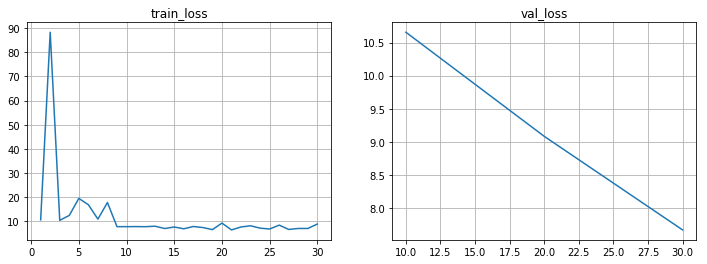

Mean loss=7.501


KeyboardInterrupt: 

In [863]:
epochs = 5
steps_per_epoch = 100

batch_generator = get_batch(data_aol, good_last_indeces_for_batch[:10000], batch_size=15)
val_queries, val_targets = get_one_batch(data_aol, good_last_indeces_for_batch[10000:11000])

feed_dict_validation = {queries: val_queries, 
                        targets: val_targets, 
                        vocab_matrix: vocab_emb_matrix}

for epoch in range(epochs):
    for iteration in range(steps_per_epoch):
        step = len(metrics['train_loss']) + 1
        
        batch_queries, batch_targets = next(batch_generator)
        
        feed_dict = {queries: batch_queries, 
                     targets: batch_targets, 
                     vocab_matrix: vocab_emb_matrix}
        
        loss_train, _ = sess.run([loss, train_step], feed_dict)
        
        metrics['train_loss'].append([step, loss_train])
        
        if step % 10 == 0:
            val_loss = sess.run(loss, feed_dict_validation)
            metrics['val_loss'].append([step, val_loss])
            
            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show();
            
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

In [866]:
def predict(model, test_data):
    test_queries = test_queries_to_matrices(test_data)
    feed_dict = {queries: test_queries, 
                 vocab_matrix: vocab_emb_matrix}

#     print(test_queries)
    predicted_tokens = [[bos_ix for _ in range(len(test_data))]]
    
    states = sess.run(init_decode_states, feed_dict)
    tokens = [np.ones(300) for _ in range(len(test_data))] #BOS words
    state = states[:,-1]
    
    for t in range(max_word_count):
        f_dict = {prev_state : state, prev_tokens : tokens, vocab_matrix: vocab_emb_matrix}
        state, logits = sess.run([next_state, next_logits], f_dict)
#         print('state, logits', state.shape, logits.shape)
        
        next_number_tokens = np.argmax(logits, axis=-1)
        predicted_tokens.append(next_number_tokens)
        
        tokens = [model_wv[indeces_to_words[id_word]] for id_word in next_number_tokens]
        
    print(np.array(predicted_tokens).shape)
    return predicted_tokens

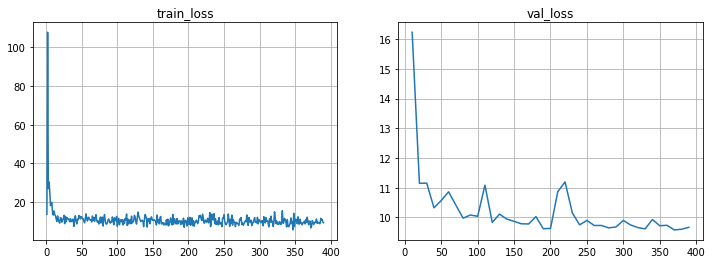

Mean loss=9.942


KeyboardInterrupt: 

In [655]:
epochs = 5
steps_per_epoch = 100

batch_generator = get_batch(data_aol, good_last_indeces_for_batch[:10000], batch_size=15)
val_queries, val_targets = get_one_batch(data_aol, good_last_indeces_for_batch[10000:11000])

feed_dict_validation = {queries: val_queries, 
                        targets: val_targets, 
                        vocab_matrix: vocab_emb_matrix}

for epoch in range(epochs):
    for iteration in range(steps_per_epoch):
        step = len(metrics['train_loss']) + 1
        
        batch_queries, batch_targets = next(batch_generator)
        
        feed_dict = {queries: batch_queries, 
                     targets: batch_targets, 
                     vocab_matrix: vocab_emb_matrix}
        
        loss_train, _ = sess.run([loss, train_step], feed_dict)
        
        metrics['train_loss'].append([step, loss_train])
        
        if step % 10 == 0:
            val_loss = sess.run(loss, feed_dict_validation)
            metrics['val_loss'].append([step, val_loss])
            
            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show();
            
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)